In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import csv, math, io, os, os.path, sys, random, time, json, gc

from astropy.io import fits

import scipy
from scipy.signal import butter,filtfilt

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

################################
# Initialisers
################################
default_rc_params = (16,5)
plt.rcParams["figure.figsize"] = default_rc_params
sb.set()

# Load the Data files
fitsarr = np.load("fitslist.npy")
xNaNs = np.load("X_NAN_LIST.npy")
xTime = np.load("X_TIME_LIST.npy")

X = np.load("None_Or_One_Exoplanet.npy")

In [2]:
########################################

def GetLCData(rndFile=-1, outputFileName=False):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        tess_bjds     = hdulist[1].data['TIME']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    
    if outputFileName:
        return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], rndFile)
    else:
        return (tess_bjds[1:-1], pdcsap_fluxes[1:-1])

########################################

def Every_Nth_Value(x,y,n):
    return (x[::n], y[::n])

########################################

def GetNumDays():
    
    xTime = np.load("X_TIME_LIST.npy")
    nDays = xTime[-1]-xTime[0]
    
    return (nDays)

########################################

def NormaliseFlux(f):
    
    # Copy to not change original dataset
    f_ = f.copy()
    
    # Normalise the Flux (y co-ords)
    median = np.median(f_)
    f_[:] = [(number/median) for number in f_]
    
    # Return nornalised flux
    return (f_)

########################################

def FIXNAN(y, xNaNs):
    yMedian = np.median(y)
    y = [yMedian if n in xNaNs else item for n,item in enumerate(y)]
    return y

########################################

def FilterMyDataNONORM(y,cutVAR=0.00005,order=2):
    
    # First, let's calculate the observational time period;
    # This is done separately so that I can change this in the future for any TESS fits file
    numdays       = GetNumDays()
    
    # Next, fix data                           
    yMedian       = np.median(y)                                                    # Get the median value of 'y' before changing it
    y             = [yMedian if n in xNaNs else item for n,item in enumerate(y)]    # Change all the missing values to the median value of the whole array
    
    # Frequency Data Stuff
    sec           = numdays*24*60*60   # Number of seconds in the overall observation period
    freq          = len(y)/sec         # Frequency, in Hz, ie number of observations per second
    # FREQ IS APPROX 1/120 OR ~0.008333333
    
    #cutoff        = cutVAR*freq        # HYPERPARAMETER NOW!!!!!!!! (has to be 0 < cutoff < 0.5 because of how normal cutoff works)
    cutoff        = cutVAR
    
    #order         = 2                  # Approximation via polynomial of the order'th degree (2=quadratic, 3=cubic, 4=quartic, etc)
    
    # Butter Lowpass Filter
    nyq           = 0.5 * freq
    normal_cutoff = cutoff / nyq
    b, a          = butter(order, normal_cutoff, btype='low', analog=False)
    newY          = filtfilt(b, a, y)
    
    # Finally, return the new X and Y values
    return (newY)

########################################

def FTTMyData(y):
    """
    Function that takes in a timeseries and then outputs a Fourier Transformed version of it
    """
    
    # FOURIER TRANSFORM THAT Y (remember to use np.nanmean instead of np.mean)
    FTY = np.fft.fft(y-np.mean(y))
    powSpectrum = np.abs(FTY)
    
    #plt.plot(F,powSpectrum)
    return(powSpectrum)

########################################

In [6]:
len(X)

9154

In [26]:
# Make max number list
maxList = [0]*len(X)

# Max Num
maxNum = -1

In [27]:
# Loop
#max(FTTMyData(FilterMyDataNONORM(NormaliseFlux(FIXNAN(X[2],xNaNs)))))
for n,i in enumerate(X):
    M = max(FTTMyData(FilterMyDataNONORM(NormaliseFlux(FIXNAN(i,xNaNs)))))
    maxList[n] = M
    maxNum = M if M > maxNum else maxNum
print(f"Maximum Is {maxNum}")

Maximum Is 129334.61844823885


In [28]:
maxList

[369.0870173308094,
 85.16402146991904,
 29.584796436563114,
 99.8143239198962,
 267.49911200095255,
 36.28467848240987,
 36.603035967574606,
 36.522842738471425,
 37.9167815944643,
 30.773754311428142,
 81.62033213330994,
 28.912911497114674,
 29.006639513706176,
 69.87968949229345,
 29.440323383400848,
 29.08539619386994,
 32.14619662212407,
 179.54143531220018,
 91.29786496253388,
 112.9929368888422,
 30.988795397193826,
 29.17867341403797,
 31.15952066819403,
 30.3218299389519,
 86.33542215306991,
 82.64559053440198,
 218.20198017076714,
 29.217156234055857,
 29.525676403086777,
 29.62213172237105,
 247.28128626081806,
 366.0063861188296,
 178.09229538100985,
 51.62652585574984,
 148.95053798657662,
 30.34137166473864,
 29.67072779624561,
 212.9568475144118,
 30.42567755171527,
 99.05877031528499,
 29.10836694846899,
 29.678116463165974,
 31.525042374631592,
 84.61295357810471,
 31.319193559921654,
 39.3949313998876,
 91.8699684331538,
 29.71139466449726,
 40.90691846541485,
 68.39

In [93]:
whereMax = maxList.index(maxNum)
whereMax

4850

In [32]:
np.mean(maxList)

105.58738156558896

In [33]:
np.std(maxList)

1477.0957620952831

In [34]:
min(maxList)

28.44384394350311

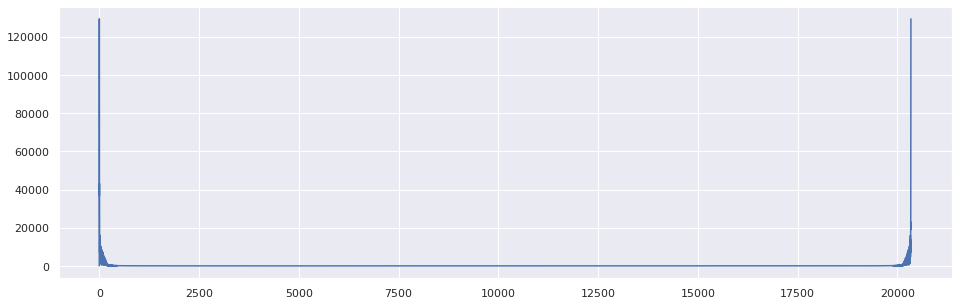

In [94]:
plt.plot(FTTMyData(FilterMyDataNONORM(NormaliseFlux(FIXNAN(X[whereMax],xNaNs)))))

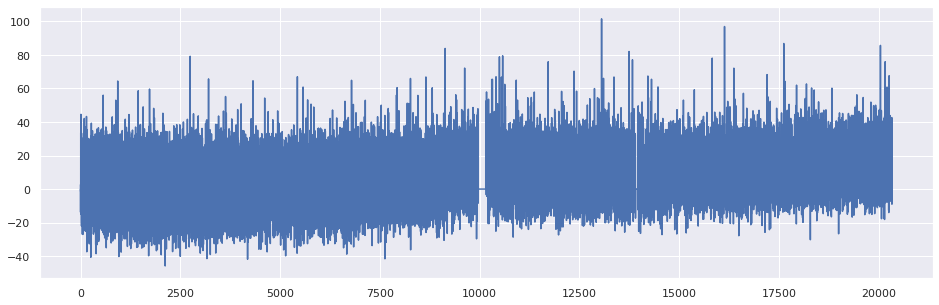

In [95]:
plt.plot(X[whereMax])

## So it seems that the average is 105 height, with a massive outlier (4850)

(-10.0, 200.0)

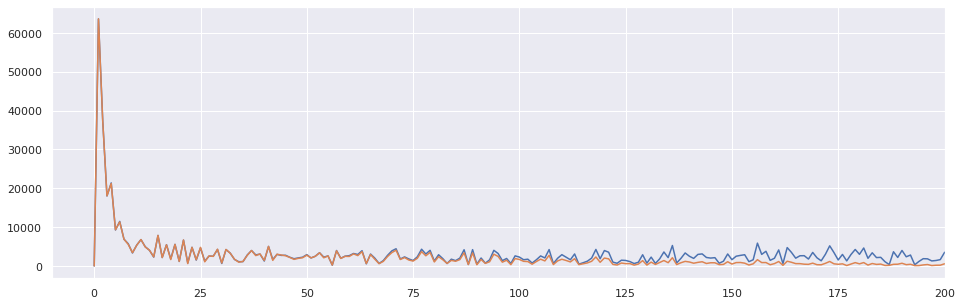

In [96]:
plt.plot(FTTMyData(X[whereMax]))
plt.plot(FTTMyData(FilterMyDataNONORM(X[whereMax])))
#plt.plot(FilterMyDataNONORM(NormaliseFlux(FIXNAN(X[whereMax],xNaNs))))
plt.xlim([-10,200])

## REDEFINING tmpY vvvvv

In [97]:
tmpY = GetLCData(whereMax)[1]

## REDEFINING tmpY ^^^^^

(-10.0, 1000.0)

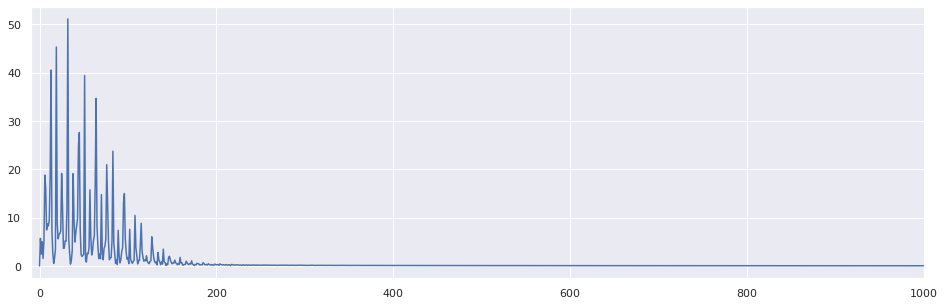

In [65]:
#plt.plot(FTTMyData(tmpY))
plt.plot(FTTMyData(FilterMyDataNONORM(NormaliseFlux(tmpY))))
plt.xlim([-10,1000])

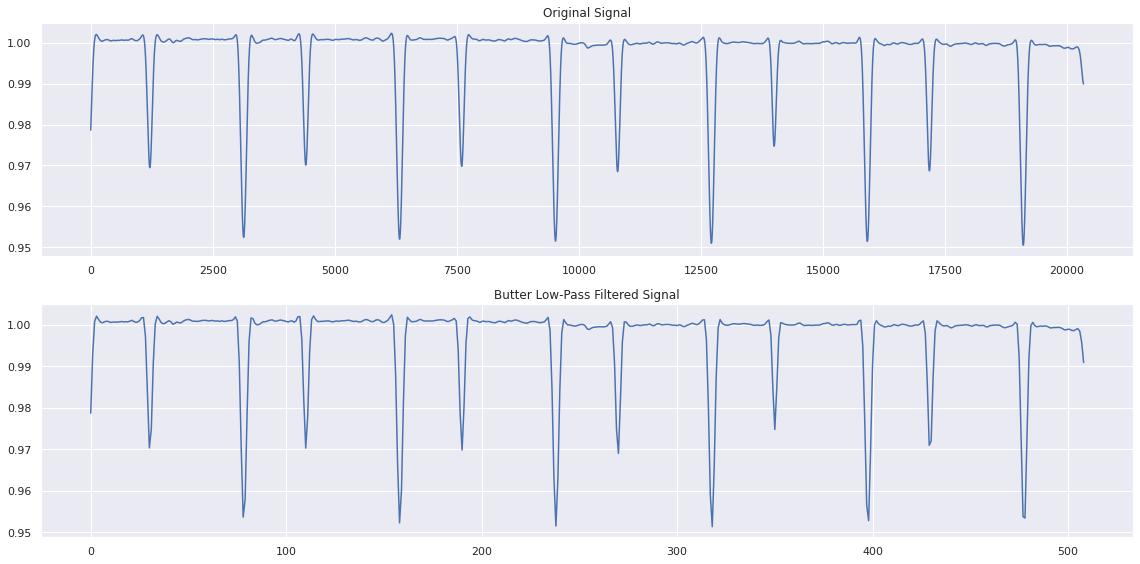

In [80]:
plt.rcParams["figure.figsize"] = (16,8)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False)

ax1.plot(FilterMyDataNONORM(NormaliseFlux(tmpY)))
ax1.set_title('Original Signal')
#ax1.set_xlabel('Time [Days (TBJD)]')

ax2.plot(FilterMyDataNONORM(NormaliseFlux(tmpY))[::40])
ax2.set_title('Butter Low-Pass Filtered Signal')
#ax2.set_xlabel('Time [Days (TBJD)]')

plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = default_rc_params

In [83]:
def interp1d(array: np.ndarray, new_len: int) -> np.ndarray:
    la = len(array)
    return np.interp(np.linspace(0, la - 1, num=new_len), np.arange(la), array)

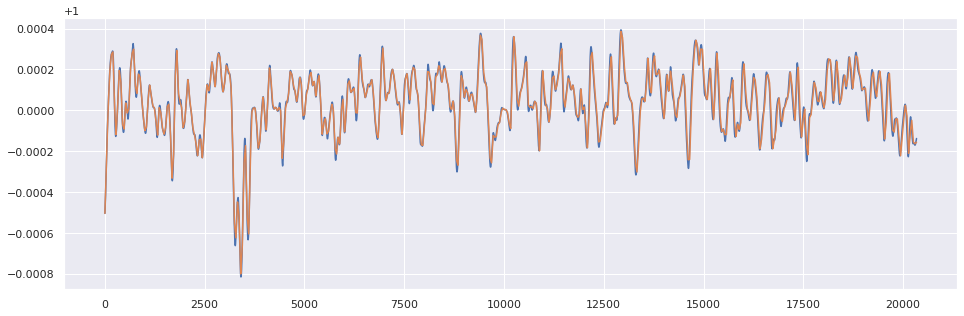

In [98]:
TST = interp1d(FilterMyDataNONORM(NormaliseFlux(tmpY))[::40], new_len=len(FilterMyDataNONORM(NormaliseFlux(tmpY))))

plt.plot(FilterMyDataNONORM(NormaliseFlux(tmpY)))
plt.plot(TST)

### Evaluation:
Even with the most massive FTT curve, every 40th number works as a subsampling.  
Next, I'll try this on the least massive FTT curve and see what happens!

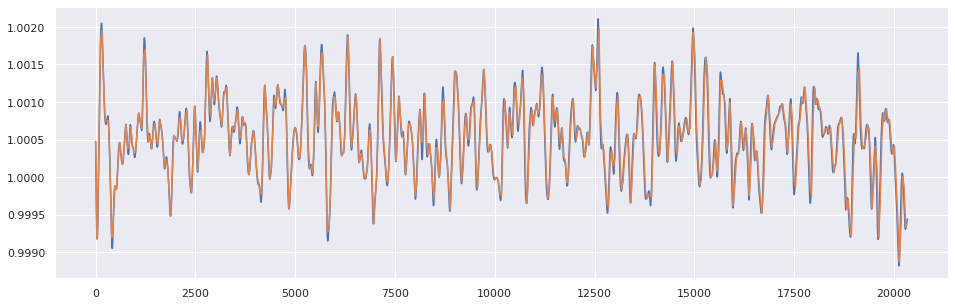

In [90]:
minNum = min(maxList)
idx = maxList.index(minNum)
tmpY = GetLCData(idx)[1]
TST = interp1d(FilterMyDataNONORM(NormaliseFlux(tmpY))[::40], new_len=len(FilterMyDataNONORM(NormaliseFlux(tmpY))))
plt.plot(FilterMyDataNONORM(NormaliseFlux(tmpY)))
plt.plot(TST)

Okay yeah we good

## EVERY NTH VALUE AS 40 WORKS PERFECTLY

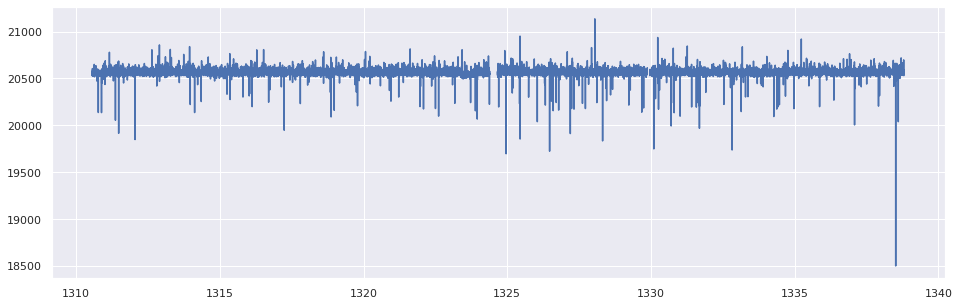

In [8]:
rnd1 = 2548
rnd2 = 17

x1, y1 = GetLCData(rnd1)[0], GetLCData(rnd1)[1]
x2, y2 = GetLCData(rnd2)[0], GetLCData(rnd2)[1]

plt.plot(x1,y1)

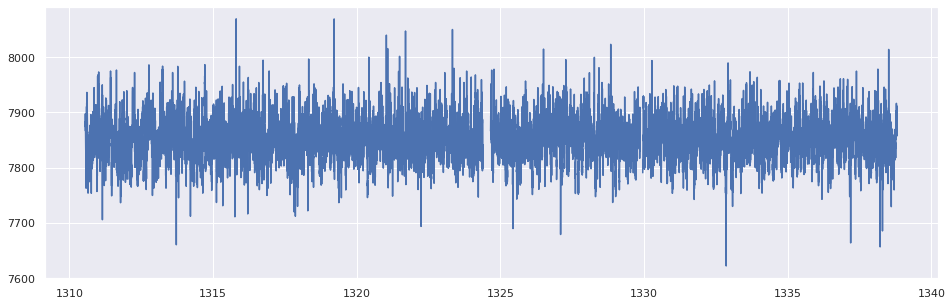

In [9]:
plt.plot(x2,y2)

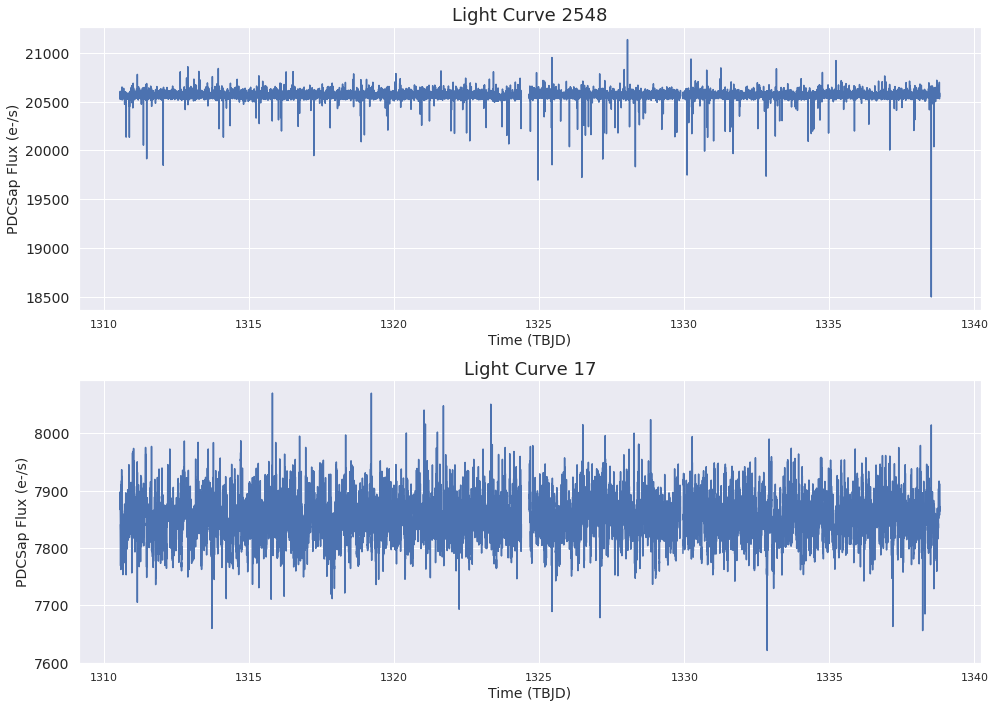

In [43]:
plt.rcParams["figure.figsize"] = (14,10)

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.4)

rnd1 = 2548
rnd2 = 17

ax1.plot(x1, y1)
ax1.set_ylabel('PDCSap Flux (e-/s)',fontdict={'fontsize': 14})
ax1.set_xlabel('Time (TBJD)',fontdict={'fontsize': 14})
ax1.set_title(f'Light Curve {rnd1}',fontdict={'fontsize': 18})
ax1.grid(True)

ax2.plot(x2, y2)
ax2.set_ylabel('PDCSap Flux (e-/s)',fontdict={'fontsize': 14})
ax2.set_xlabel('Time (TBJD)',fontdict={'fontsize': 14})
ax2.set_title(f'Light Curve {rnd2}',fontdict={'fontsize': 18})
ax2.grid(True)

ax1.tick_params(axis='y', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=14)

plt.tight_layout()
plt.savefig("./img/lc-scales.png")
plt.show()



plt.rcParams["figure.figsize"] = default_rc_params